In [1]:
using Distributions
using PyPlot

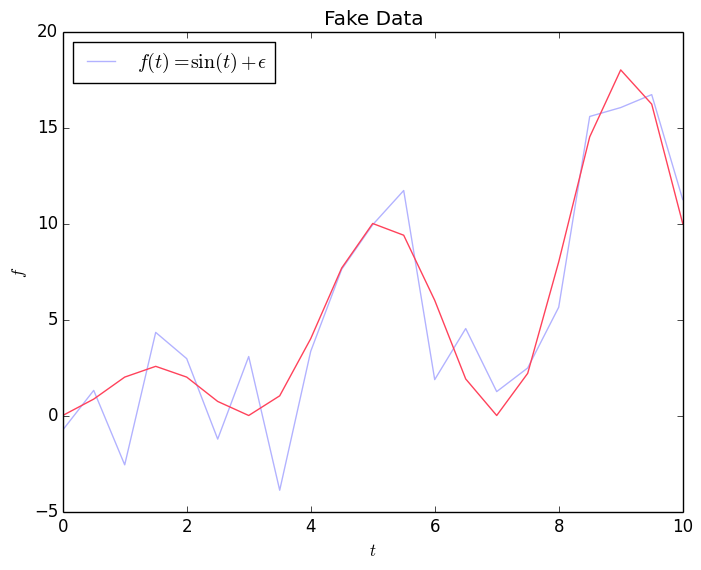

PyObject <matplotlib.legend.Legend object at 0x31ef87f50>

In [2]:
# define some fake data

t = collect(0:0.5:10)
y_true = t.*sin(0.25*2π*t) + t
y = y_true + randn!(zeros(t))*2

plot(t,y, label="\$f(t) = \\sin(t) + \\epsilon\$", alpha=0.3)
plot(t, y_true, color="#FF425B")
title("Fake Data")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="upper left")

In [3]:
# squared exponential kernel type
# to store params
type SEKernel
    l2::Float64 # (length-scale)^2
    σ2::Float64 # function (std-dev)^2
    SEKernel(l::Float64,σ::Float64) = new(l^2,σ^2)
end

# kernel defintion for SE kernel
function kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    diff = x - x_
    return se.σ2 * exp(-diff'*diff/(2se.l2))[1]
end

# create convariance matrix K
# X,X_ have rows of data points
function K(se::SEKernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = kern(se, X[i,:], X_[j,:])
        end
    end
    return K_
end

function K(se::SEKernel, x::Float64,x_::Float64)
    return kern(se, [x], [x_])
end

K (generic function with 2 methods)

In [27]:
x = [1. 2. 3. 4. 5. 6.]'

σ = 2.
l = 1.
se = SEKernel(l,σ)

K(se, x, x)

6x6 Array{Float64,2}:
 4.0         2.42612     0.541341  0.044436  0.00134185  1.49066e-5
 2.42612     4.0         2.42612   0.541341  0.044436    0.00134185
 0.541341    2.42612     4.0       2.42612   0.541341    0.044436  
 0.044436    0.541341    2.42612   4.0       2.42612     0.541341  
 0.00134185  0.044436    0.541341  2.42612   4.0         2.42612   
 1.49066e-5  0.00134185  0.044436  0.541341  2.42612     4.0       

In [134]:
# signal noise
σ_y = 2.0

println("==> Construct Kernels")
t_ = collect(0:0.01:15)
K_ = K(se, t, t)
K_ = K_ + σ_y*eye(K_)

k_ = K(se, t, t_)
k__ = K(se, t_,t_)


println("==> Run GP Regression")
# GP Regression algorithm
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L'\(L\y)
μ = k_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP = -y'*α/2 - sum(log(diag(L))) - size(y)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP[1])")

==> Construct Kernels
==> Run GP Regression
--  done.
==> Marginal Likelihood: log P(y|X) = -106.90147829985474


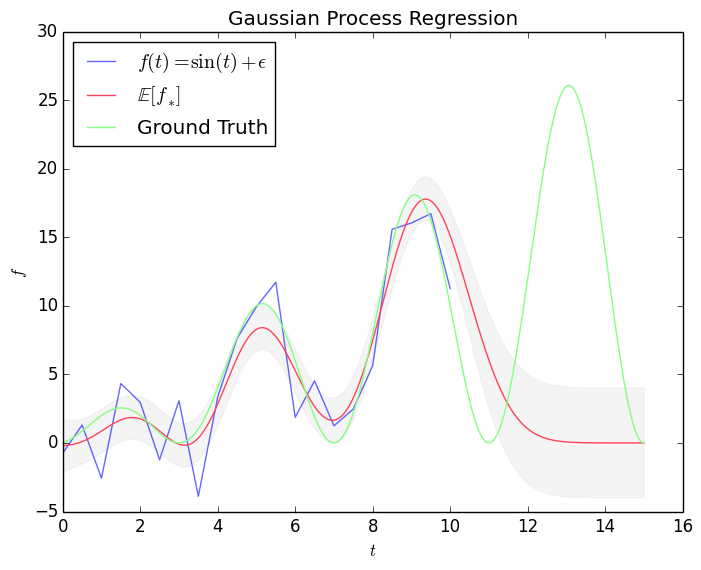

PyObject <matplotlib.legend.Legend object at 0x31f998ad0>

In [135]:
plot(t,y, label="\$f(t) = \\sin(t) + \\epsilon\$", alpha=0.6)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
plot(t_, t_.*sin(0.25*2π*t_) + t_, label="Ground Truth", color="#84FF80")
title("Gaussian Process Regression")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="upper left")